In [3]:
import sys
sys.path.append("src")
%load_ext autoreload
%autoreload 2

from trans_models import TextClassification
from benchmark import (
    DatasetItemCallbackNLP,
    Benchmark,
)

import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def dataset_process(dataset):
    return dataset["train"].select(range(5000))

model = TextClassification(
    model_name="nateraw/bert-base-uncased-imdb",
    torchscript=True
)

dataset_item_callback = DatasetItemCallbackNLP(
    tokenizer=model._tokenizer,
)

benchmark = Benchmark(
    dataset="carblacac/twitter-sentiment-analysis",
    batch_sizes=[1, 5, 10, 20, 30, 40],
    dataset_process_callback=dataset_process,
    data_item_process_callback=dataset_item_callback.process
)

Found cached dataset twitter-sentiment-analysis (/root/.cache/huggingface/datasets/carblacac___twitter-sentiment-analysis/default/1.0.0/cd65e23e456de6a4f7264e305380b0ffe804d6f5bfd361c0ec0f68d8d1fab95b)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
results = []

results.extend(
    benchmark.excecute(
        model.export_to_native(device="cuda"),
        name="native"
    )
)

results.extend(
    benchmark.excecute(
        model.export_to_traced_jit(device="cuda"),
        name="traced_jit"
    )
)

results.extend(
    benchmark.excecute(
        model.export_to_onnx("cuda"),
        name="onnx"
    )
)

results.extend(
    benchmark.excecute(
        model.export_to_tensorrt(max_batch_size=40),
        name="TensorRT"
    )
)

native
traced_jit
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



2023-04-24 19:39:15.176681636 [W:onnxruntime:, session_state.cc:1136 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-04-24 19:39:15.176730755 [W:onnxruntime:, session_state.cc:1138 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


onnx
================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

[04/24/2023-19:47:46] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[04/24/2023-19:47:46] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[[1, 1], [1, 1]]
Binding input_ids with min_shape: [1, 1], max_shape: [40, 512], opt_shape: [20, 256]
Binding attention_mask with min_shape: [1, 1], max_shape: [40, 512], opt_shape: [20, 256]
[04/24/2023-19:48:01] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usa

In [7]:
df = pd.DataFrame(results)

In [8]:
df["duration_per_example"] = df["duration"] / df["batch_size"] 

<Axes: xlabel='batch_size', ylabel='duration_per_example'>

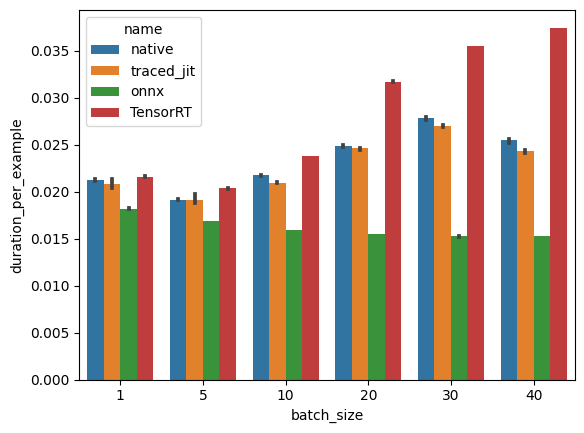

In [9]:
sns.barplot(x="batch_size", y="duration_per_example", hue="name", data=df)

<Axes: xlabel='batch_size', ylabel='duration_per_example'>

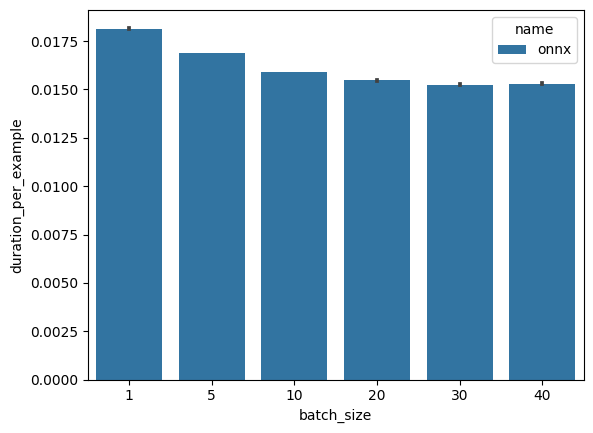

In [10]:
sns.barplot(x="batch_size", y="duration_per_example", hue="name", data=df.loc[df["name"] == "onnx"])

In [14]:
def normalize(x):
    normalzier = x.loc[x["name"] == "native"].duration_per_example.values[0]
    x["duration_per_example"] = x["duration_per_example"] / normalzier
    return x

df_aggr = df.groupby(["batch_size", "name"])["duration_per_example"].mean().reset_index()
df_aggr_norm = df_aggr.groupby(["batch_size"]).apply(normalize).reset_index(drop=True)

<Axes: xlabel='batch_size', ylabel='duration_per_example'>

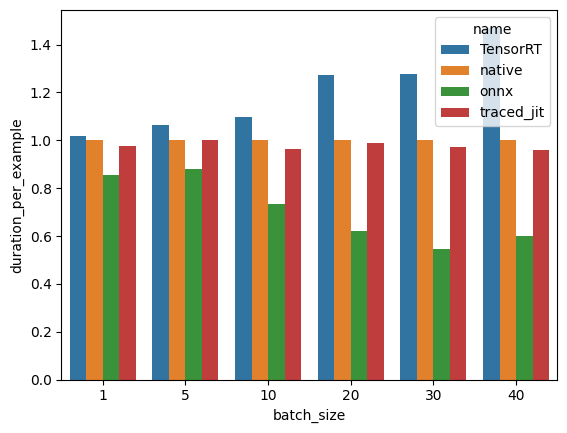

In [15]:
sns.barplot(x="batch_size", y="duration_per_example", hue="name", data=df_aggr_norm)

<Axes: xlabel='batch_size', ylabel='duration_per_example'>

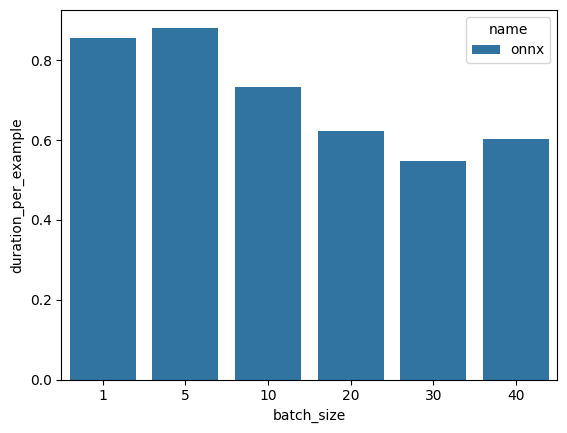

In [16]:
sns.barplot(x="batch_size", y="duration_per_example", hue="name", data=df_aggr_norm.loc[df_aggr_norm["name"] == "onnx"])